In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import sys
sys.path.append('../')
from utils import get_mat
import networkx as nx

### Load data, merge experiments, calculate normalized scores

In [20]:
directory_path = '../our_results'

# Get a list of all CSV files in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path)
    
    # Define the pattern
    pattern = re.compile(r'([\w-]+)_(\d+\.\d+)_(\d+\.\d+)_(\d+\.\d+)_(\d+)\.csv')

    # Use the pattern to extract values
    match = pattern.match(file)

    # Check if the string matches the pattern
    if match:
        # Extract values from the match object
        df['dataset'] = match.group(1)
        e1 = float(match.group(3))
        df['e1'] = e1
        e2 = float(match.group(4))
        df['e2'] = e2
        df['e3'] = 1.0 - e1 - e2
    else:
        print(file + " doesn't match!")
        continue
        
    dfs.append(df)

# Concatenate the list of DataFrames into a single DataFrame
dfs = pd.concat(dfs, ignore_index=True)

# take the average of all experiments
dfs = dfs.groupby(['eps', 'N', 'dataset', 'e1', 'e2']).mean().reset_index()
dfs = dfs.drop('exper', axis=1)

dfs

,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3
0,0.5,5.0,Bitcoin,0.1,0.1,0.143892,0.027027,0.051316,3.504935,0.2600,0.978952,0.415654,0.8
1,0.5,5.0,Bitcoin,0.1,0.3,0.137943,0.016216,0.050437,3.395143,0.2100,0.982516,0.439216,0.6
2,0.5,5.0,Bitcoin,0.1,0.4,0.149094,0.008108,0.063115,3.354910,0.2500,0.972154,0.435042,0.5
3,0.5,5.0,Bitcoin,0.1,0.5,0.147347,0.013514,0.052128,3.343561,0.2400,0.965051,0.434195,0.4
4,0.5,5.0,Bitcoin,0.1,0.6,0.152328,0.008108,0.051528,3.110713,0.2900,0.958265,0.397582,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591,3.5,35.0,Facebook,0.4,0.4,0.211623,0.672500,0.008383,0.332793,0.2625,0.631651,0.326553,0.2
2592,3.5,35.0,Facebook,0.4,0.5,0.242776,0.655000,0.007636,0.351442,0.1500,0.596279,0.342098,0.1
2593,3.5,35.0,Facebook,0.5,0.1,0.154159,0.712500,0.005143,0.451522,0.2125,0.525142,0.410727,0.4
2594,3.5,35.0,Facebook,0.5,0.3,0.207987,0.665000,0.008607,0.363541,0.2250,0.605318,0.335231,0.2


In [21]:
# apply Z-Score Normalization for the metrics and add graph info at the dataset level
datasets = dfs['dataset'].unique()
metrics = cols = ['nmi','evc_overlap','evc_MAE','deg_kl', 'diam_rel','cc_rel','mod_rel']
for dataset in datasets:
    data_path = '../data/' + dataset + '.txt'
    mat0,mid = get_mat(data_path)
    mat0_graph = nx.from_numpy_array(mat0,create_using=nx.Graph)
    dfs.loc[dfs['dataset'] == dataset,'nodes'] = mat0_graph.number_of_nodes()
    dfs.loc[dfs['dataset'] == dataset,'edges'] = mat0_graph.number_of_edges()
    
    dfs.loc[dfs['dataset'] == dataset, metrics] = dfs.loc[dfs['dataset'] == dataset, metrics].apply(zscore)
    
dfs['density'] = dfs['edges']/dfs['nodes']

# invert certain metrics that are better when the values are smaller
for col in ['evc_MAE','deg_kl', 'diam_rel','cc_rel','mod_rel']:
    dfs[col] = -dfs[col]
    
# calculate a score based on normalized metrics. The larger the score the better.
dfs['score'] = dfs[metrics].sum(axis=1)

dfs

,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
0,0.5,5.0,Bitcoin,0.1,0.1,0.459455,-0.927455,-1.787169,-5.010274,-0.553802,-1.347003,-2.317652,0.8,3783.0,14124.0,3.733545,-11.483899
1,0.5,5.0,Bitcoin,0.1,0.3,0.086402,-0.970758,-1.712342,-4.755293,0.153737,-1.360929,-2.548909,0.6,3783.0,14124.0,3.733545,-11.108091
2,0.5,5.0,Bitcoin,0.1,0.4,0.785670,-1.003235,-2.791465,-4.661855,-0.412294,-1.320436,-2.507943,0.5,3783.0,14124.0,3.733545,-11.911557
3,0.5,5.0,Bitcoin,0.1,0.5,0.676117,-0.981584,-1.856241,-4.635496,-0.270786,-1.292681,-2.499629,0.4,3783.0,14124.0,3.733545,-10.860301
4,0.5,5.0,Bitcoin,0.1,0.6,0.988450,-1.003235,-1.805216,-4.094726,-0.978325,-1.266161,-2.140281,0.3,3783.0,14124.0,3.733545,-10.299494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2591,3.5,35.0,Facebook,0.4,0.4,0.540907,0.640156,0.371456,0.641884,0.161205,0.173173,0.745299,0.2,4039.0,88234.0,21.845506,3.274079
2592,3.5,35.0,Facebook,0.4,0.5,0.972194,0.576204,0.439264,0.630337,1.627762,0.348849,0.666496,0.1,4039.0,88234.0,21.845506,5.261105
2593,3.5,35.0,Facebook,0.5,0.1,-0.254628,0.786331,0.665525,0.568373,0.813008,0.702156,0.318579,0.4,4039.0,88234.0,21.845506,3.599343
2594,3.5,35.0,Facebook,0.5,0.3,0.490572,0.612748,0.351092,0.622846,0.650057,0.303958,0.701308,0.2,4039.0,88234.0,21.845506,3.732582


In [12]:
# top 10 combos for Chamelon
dfs[dfs['dataset'] == "Facebook"].nlargest(10, "score")

,eps,N,dataset,e1,e2,nmi,evc_overlap,evc_MAE,deg_kl,diam_rel,cc_rel,mod_rel,e3,nodes,edges,density,score
2056,3.5,5.0,Facebook,0.5,0.3,1.873738,0.987323,1.080458,0.592488,2.279565,2.218426,1.355935,0.2,4039.0,88234.0,21.845506,10.387932
2053,3.5,5.0,Facebook,0.4,0.4,1.894613,1.069547,1.052535,0.642389,0.487106,1.892067,1.507733,0.2,4039.0,88234.0,21.845506,8.545989
2135,3.5,10.0,Facebook,0.3,0.6,1.601063,0.841147,0.943658,0.659089,1.953663,0.935579,1.316407,0.1,4039.0,88234.0,21.845506,8.250607
2046,3.5,5.0,Facebook,0.3,0.3,1.783372,1.142635,1.031811,0.641784,0.324156,1.747924,1.407829,0.4,4039.0,88234.0,21.845506,8.079511
2048,3.5,5.0,Facebook,0.3,0.5,2.022117,0.859419,1.037458,0.641777,0.650057,1.464654,1.379193,0.2,4039.0,88234.0,21.845506,8.054676
2052,3.5,5.0,Facebook,0.4,0.3,1.732042,1.087819,1.071648,0.634288,-0.001746,1.908565,1.456718,0.3,4039.0,88234.0,21.845506,7.889334
2051,3.5,5.0,Facebook,0.4,0.2,1.396759,1.042139,1.068668,0.630200,0.161205,2.049246,1.324969,0.4,4039.0,88234.0,21.845506,7.673186
2054,3.5,5.0,Facebook,0.4,0.5,1.983206,0.850283,1.027092,0.652384,-0.164697,1.588224,1.534571,0.1,4039.0,88234.0,21.845506,7.471063
2049,3.5,5.0,Facebook,0.3,0.6,2.205501,0.822875,0.987981,0.667700,0.161205,1.171846,1.428007,0.1,4039.0,88234.0,21.845506,7.445114
2057,3.5,5.0,Facebook,0.7,0.1,0.620199,1.051275,1.056173,0.599536,0.487106,2.198891,1.215361,0.2,4039.0,88234.0,21.845506,7.228542


### Multi-Linear Regression model

Mean Squared Error: 7.466185497326545
R-squared: 0.8135696667865574


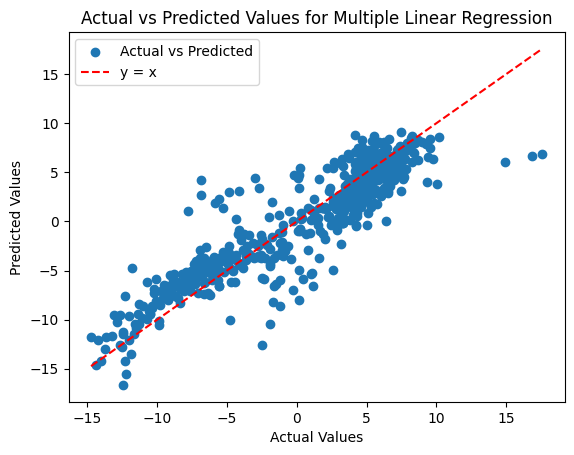

In [13]:
# construct other predictors for the model from parameters
dfs['eps*N'] = dfs['eps'] * dfs['N']
dfs['(eps*N)**2'] = dfs['eps*N']**2
dfs['eps**2'] =  np.square(dfs['eps'])
dfs['e1*e2'] = dfs['e1'] * dfs['e2']
dfs['e1**2'] = np.square(dfs['e1'])
dfs['e2**2'] = np.square(dfs['e2'])
dfs['N**2'] = np.square(dfs['N'])
dfs['N**3'] = np.power(dfs['N'], 3)
dfs['N*e1'] = dfs['N'] * (dfs['e1'] - dfs['e1**2'])
dfs['N*e2'] = dfs['N'] * (dfs['e2'] - dfs['e1**2'])
dfs['(e1+e2)/e3'] = dfs['e1'] + dfs['e2'] / dfs['e3']
dfs['e1*eps'] = dfs['e1'] * dfs['eps']
dfs['e2*eps'] = dfs['e2'] * dfs['eps']
dfs['(e1*eps)**2'] = np.square(dfs['e1*eps'])
dfs['(e2*eps)**2'] = np.square(dfs['e2*eps'])
dfs['N*e1*eps'] = dfs['N'] * dfs['e1*eps']
dfs['N*e2*eps'] = dfs['N'] * dfs['e2*eps']

variables = ['eps', 'N', 'e1', 'e2', 'eps*N', 'e1**2', 'e2**2', 'eps**2', 'e1*e2', 'N*e1', 'N*e2',\
    '(e1+e2)/e3', 'N**2', 'N**3', 'e1*eps', 'e2*eps', '(e1*eps)**2', '(e2*eps)**2', 'N*e1*eps', 'N*e2*eps', 'nodes', 'edges', 'density', '(eps*N)**2']
# Split the data into features (X) and target variable (y)
X = dfs[variables]
y = dfs['score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize the linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the predicted vs actual values
plt.scatter(y_test, y_pred, label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y = x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Multiple Linear Regression')
plt.legend()
plt.show()

Mean Squared Error: 6.686439821179494
R-squared: 0.8253204470059294


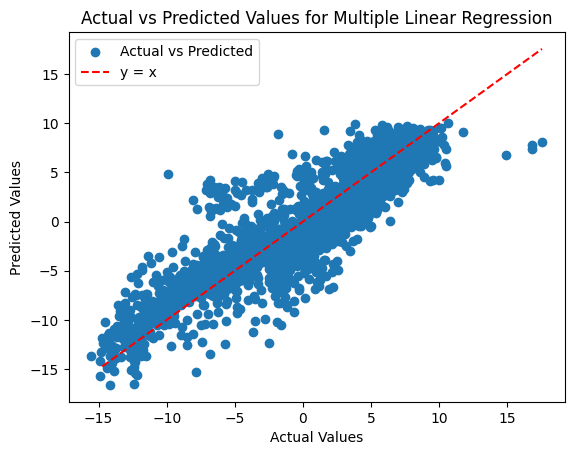

In [14]:
# the model if it had access to all the data, not just training (as good as it's gonna get?)
model2 = LinearRegression()

# Train the model
model2.fit(X, y)

# Make predictions on the test set
y_pred2 = model2.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred2)
r2 = r2_score(y, y_pred2)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the predicted vs actual values
plt.scatter(y, y_pred2, label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='y = x')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Multiple Linear Regression')
plt.legend()
plt.show()

In [15]:
# Calculate residuals
residuals = y_test - y_pred

# Calculate MSE for each data point
mse_per_point = np.square(residuals)

# Find the indices of the points with the highest MSE
indices_highest_mse = mse_per_point.nlargest(30).index   # Adjust the number of points to display

test_set = dfs.iloc[y_test.index]
test_set['pred'] = y_pred
test_set['diff'] = np.square(test_set['score'] - test_set['pred'])

/var/folders/r9/dg66n5vj32z_jl7f7k8wjsx80000gn/T/ipykernel_43440/3960316184.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['pred'] = y_pred
/var/folders/r9/dg66n5vj32z_jl7f7k8wjsx80000gn/T/ipykernel_43440/3960316184.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['diff'] = np.square(test_set['score'] - test_set['pred'])


In [16]:
# largest differences in prediction
test_set.sort_values(by='diff', ascending=False)[:17][['eps', 'N', 'dataset', 'e1', 'e2','pred', 'score', 'diff']]

,eps,N,dataset,e1,e2,pred,score,diff
2370,3.5,25.0,Congress,0.5,0.1,4.243011,-6.836962,122.765806
2498,3.5,35.0,CA-HepPh,0.1,0.1,6.831662,17.569082,115.292190
2412,3.5,30.0,CA-HepPh,0.1,0.1,6.712215,16.853301,102.841625
142,0.5,10.0,Congress,0.1,0.1,-12.562252,-2.474845,101.755781
2542,3.5,35.0,Congress,0.5,0.1,2.742633,-6.837602,91.780906
1113,2.0,5.0,Bitcoin,0.1,0.5,1.106773,-7.760005,78.619751
2240,3.5,20.0,CA-HepPh,0.1,0.1,6.033227,14.897807,78.580779
231,0.5,15.0,Congress,0.1,0.1,-10.425966,-1.931693,72.152679
149,0.5,10.0,Congress,0.5,0.1,-7.948304,0.148315,65.555235
1652,2.0,35.0,Congress,0.7,0.1,2.315090,-5.559597,62.010694


In [17]:
# After training the model
coefficients = model.coef_  # Coefficients for each feature
intercept = model.intercept_  # Intercept

# Display the equation
equation = f'y = {intercept:.4f}\n'
for i, var in enumerate(variables):
    if coefficients[i] >= 0.0 :
        equation += "+ "
    equation += f'{coefficients[i]:.4f} * '+ var +"\n"
# print("Linear Regression Equation:")
print(equation)

y = -31.8253
+ 7.9796 * eps
+ 0.8842 * N
+ 16.3715 * e1
+ 9.5628 * e2
-0.0695 * eps*N
-5.2665 * e1**2
-10.2953 * e2**2
-1.2468 * eps**2
-16.8360 * e1*e2
-0.3115 * N*e1
+ 0.1743 * N*e2
+ 0.1631 * (e1+e2)/e3
-0.0188 * N**2
+ 0.0001 * N**3
+ 5.2806 * e1*eps
+ 11.7847 * e2*eps
-1.4833 * (e1*eps)**2
-2.6315 * (e2*eps)**2
-0.0666 * N*e1*eps
-0.1352 * N*e2*eps
+ 0.0016 * nodes
-0.0001 * edges
+ 0.2814 * density
+ 0.0003 * (eps*N)**2



In [18]:
equation = f'y = {intercept:.4f}'
for i, var in enumerate(variables):
    if coefficients[i] >= 0.0 :
        equation += "+ "
    equation += f'{coefficients[i]:.4f} * '+ var +" "
# print("Linear Regression Equation:")
print(equation)

y = -31.8253+ 7.9796 * eps + 0.8842 * N + 16.3715 * e1 + 9.5628 * e2 -0.0695 * eps*N -5.2665 * e1**2 -10.2953 * e2**2 -1.2468 * eps**2 -16.8360 * e1*e2 -0.3115 * N*e1 + 0.1743 * N*e2 + 0.1631 * (e1+e2)/e3 -0.0188 * N**2 + 0.0001 * N**3 + 5.2806 * e1*eps + 11.7847 * e2*eps -1.4833 * (e1*eps)**2 -2.6315 * (e2*eps)**2 -0.0666 * N*e1*eps -0.1352 * N*e2*eps + 0.0016 * nodes -0.0001 * edges + 0.2814 * density + 0.0003 * (eps*N)**2 


### finding the a good set of parameters using scipy.optimize

In [19]:
from scipy.optimize import minimize

# Define the function to minimize
def objective_function(variables):
    eps = 2.5
    nodes = 4000
    edges = 60000
    density = 0
    N, e1, e2, e3 = variables
    y = -30.4020+ 12.8055 * eps + 0.7659 * N + 20.4504 * e1 + 10.7168 * e2 -0.0921 * eps*N -10.6752 * e1**2 -6.9766 * e2**2 -1.9768 * eps**2 -15.6803 * e1*e2 -0.2167 * N*e1 + 0.0960 * N*e2 + 0.1402 * (e1+e2)/e3 -0.0148 * N**2 + 0.0001 * N**3 + 3.1916 * e1*eps + 7.0388 * e2*eps -0.6629 * (e1*eps)**2 -1.6006 * (e2*eps)**2 -0.0997 * N*e1*eps -0.1143 * N*e2*eps + 0.0016 * nodes -0.0001 * edges -0.0000 * density + 0.0004 * (eps*N)**2 

    return -y

# Initial guess for variable values
initial_guess = [60.0, 0.4, 0.4, 0.2]

# Define bounds for the variables if needed
bounds = [ (0, 70), (0.01, 1), (0.1, 1), (0.1, 1)]

# Perform the minimization
result = minimize(objective_function, initial_guess, bounds=bounds, constraints={'type': 'eq', 'fun': lambda x: x[1] + x[2] + x[3]- 1.0 })

# Extract the optimal variable values
optimal_values = result.x

print("Optimal Variable Values:", optimal_values)
print("Minimum Value of y:", result.fun)

Optimal Variable Values: [7.00000000e+01 1.00000000e-02 4.52263098e-01 5.37736902e-01]
Minimum Value of y: -4.513412340121899


### Selecting features automatically with RFE (doesn't actually work as well)

In [12]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt


In [13]:
variables = ['eps', 'N', 'e1', 'e2', 'nodes', 'edges']
# Split the data into features (X) and target variable (y)
X = dfs[variables]
y = dfs['score']

# Create polynomial features
degree = 5  # Set the degree of polynomial features
poly = PolynomialFeatures(degree)
X_poly = poly.fit_transform(X)

# Initialize the linear regression model
model = LinearRegression()

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
selector = RFE(estimator=model, step=1, n_features_to_select = 25)

# Fit RFE on the polynomial features
selector = selector.fit(X_poly, y)

# # Get the selected features
selected_features_indices = selector.support_
selected_features = X_poly[:,selected_features_indices]

In [14]:
len(selected_features_indices)

462

In [15]:
poly.powers_[selected_features_indices]

array([[1, 0, 0, 0, 0, 0],
       [2, 1, 0, 0, 0, 1],
       [1, 1, 0, 1, 0, 1],
       [4, 0, 0, 0, 0, 1],
       [3, 1, 0, 0, 1, 0],
       [3, 1, 0, 0, 0, 1],
       [3, 0, 1, 0, 0, 1],
       [2, 1, 1, 0, 0, 1],
       [2, 1, 0, 1, 0, 1],
       [2, 0, 2, 0, 0, 1],
       [2, 0, 1, 0, 2, 0],
       [2, 0, 0, 2, 0, 1],
       [1, 2, 0, 1, 1, 0],
       [1, 1, 2, 0, 0, 1],
       [1, 0, 1, 1, 2, 0],
       [1, 0, 0, 2, 2, 0],
       [0, 4, 1, 0, 0, 0],
       [0, 4, 0, 1, 0, 0],
       [0, 2, 2, 0, 1, 0],
       [0, 2, 1, 1, 1, 0],
       [0, 2, 1, 1, 0, 1],
       [0, 2, 0, 2, 1, 0],
       [0, 1, 3, 0, 0, 1],
       [0, 1, 2, 0, 2, 0],
       [0, 0, 2, 1, 1, 1]])

In [16]:
X_feat = pd.DataFrame()
for ic, combo in enumerate(poly.powers_[selected_features_indices]):
    vars = []
    for i, pow in enumerate(combo):
        if pow > 0:
            var = X.columns[i] 
            if pow > 1:
                var += "**" + str(pow) 
            vars.append(var)
            
    name = '+'.join(vars)
            
    X_feat[name] = X.apply(lambda row: 
        np.sum([np.power(row[X.columns[ri]], combo[ri]) for ri in range(len(combo)) if combo[ri] > 0]), axis=1)
    # print(np.power(X, combo))
    # X_feat[name] = np.power(X, combo)
  
X_feat  

,eps,eps**2+N+edges,eps+N+e2+edges,eps**4+edges,eps**3+N+nodes,eps**3+N+edges,eps**3+e1+edges,eps**2+N+e1+edges,eps**2+N+e2+edges,eps**2+e1**2+edges,...,eps+e2**2+nodes**2,N**4+e1,N**4+e2,N**2+e1**2+nodes,N**2+e1+e2+nodes,N**2+e1+e2+edges,N**2+e2**2+nodes,N+e1**3+edges,N+e1**2+nodes**2,e1**2+e2+nodes+edges
0,0.5,118494.25,118494.6,118489.0625,12013.125,118494.125,118489.225,118494.35,118494.35,118489.26,...,1.441921e+08,625.1,625.1,12033.01,12033.2,118514.2,12033.01,118494.001,1.441921e+08,130497.11
1,0.5,118494.25,118494.7,118489.0625,12013.125,118494.125,118489.225,118494.35,118494.45,118489.26,...,1.441921e+08,625.1,625.2,12033.01,12033.3,118514.3,12033.04,118494.001,1.441921e+08,130497.21
2,0.5,118494.25,118494.8,118489.0625,12013.125,118494.125,118489.225,118494.35,118494.55,118489.26,...,1.441921e+08,625.1,625.3,12033.01,12033.4,118514.4,12033.09,118494.001,1.441921e+08,130497.31
3,0.5,118494.25,118494.9,118489.0625,12013.125,118494.125,118489.225,118494.35,118494.65,118489.26,...,1.441921e+08,625.1,625.4,12033.01,12033.5,118514.5,12033.16,118494.001,1.441921e+08,130497.41
4,0.5,118494.25,118495.0,118489.0625,12013.125,118494.125,118489.225,118494.35,118494.75,118489.26,...,1.441921e+08,625.1,625.5,12033.01,12033.6,118514.6,12033.25,118494.001,1.441921e+08,130497.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2091,3.5,88281.25,88272.9,88384.0625,4116.875,88311.875,88277.275,88281.65,88281.65,88246.41,...,1.631352e+07,1500625.4,1500625.4,5264.16,5264.8,89459.8,5264.16,88269.064,1.631356e+07,92273.56
2092,3.5,88281.25,88273.0,88384.0625,4116.875,88311.875,88277.275,88281.65,88281.75,88246.41,...,1.631352e+07,1500625.4,1500625.5,5264.16,5264.9,89459.9,5264.25,88269.064,1.631356e+07,92273.66
2093,3.5,88281.25,88272.6,88384.0625,4116.875,88311.875,88277.375,88281.75,88281.35,88246.50,...,1.631352e+07,1500625.5,1500625.1,5264.25,5264.6,89459.6,5264.01,88269.125,1.631356e+07,92273.35
2094,3.5,88281.25,88272.8,88384.0625,4116.875,88311.875,88277.375,88281.75,88281.55,88246.50,...,1.631352e+07,1500625.5,1500625.3,5264.25,5264.8,89459.8,5264.09,88269.125,1.631356e+07,92273.55


In [9]:
import csv

for file in csv_files:
    csv_file_path = os.path.join(directory_path, file)
    

    # Header to check or add
    desired_header = [
        "eps",
        "exper",
        "N",
        "nmi",
        "evc_overlap",
        "evc_MAE",
        "deg_kl",
        "diam_rel",
        "cc_rel",
        "mod_rel",
    ]

    # Read the existing contents
    with open(csv_file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        existing_content = list(reader)

    # Check if the first line matches the desired header
    if existing_content and existing_content[0] != desired_header :
        # existing_content.pop(1)
        # Add the header as the first line
        existing_content.insert(0, desired_header)

        # Write back to the CSV file
        with open(csv_file_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(existing_content)

        # print("Header added as the first line.")
